<a href="https://colab.research.google.com/github/RvsL/kaggle/blob/main/eruptions_dist_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Competition about predicting volcano eruption time
  up to now i've already done a notebook on kaggle, scored 5,2e6
  done it with LGBM, but i can't improve on given features.

  So, aim of this current work is to find optimal features. Features are obtained by splitting a frequency diagrams of 10 sensors into some parts and summarizing those parts. So, obviously, i should find this optimal divistion. That was the prime idea. But then i understood that i need to get most accurate splits, then get best features from each of them, and concatenate the result. And build regressor on those features. 

  This appreach seems to be most promising because i've got too many features, and it may lead to contradiction in learning. At the same time, choosing best split avoids me from having good features from other splits, which score not so good, but that doesn't mean the features cant't improve performance of the best model.

  I've got a concern regarding multicollinearity of those features, as they carry about the same information. That's the thing to verify.

In [ ]:
import pandas as pd
import numpy as np
import zipfile as zf
import os
import datetime as dt
from tqdm import tqdm, tqdm_notebook
import re
import string
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')


def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
def tstats(t, doplot = False):
    print('#'*20, get_df_name(t), t.shape)
    for _,i in enumerate(t):
        nulls = t[i].isna().sum()
        if nulls > 0:
            print(i,'=', t[i].nunique(), ',NULLS = ', nulls, ',% of nulls = ',round(100*nulls/t.shape[0]))
        else:
            print(i,'=', t[i].nunique())
    if doplot:
        print()
        print(t.sample(10))
        print()
        
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.cluster import KMeans

import scipy.fftpack
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences

homedir = '/content/drive/MyDrive/2 - рабочее/32 - PMI/random/'



https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$4
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 20861 (delta 68), reused 68 (delta 41), pack-reused 20734
Receiving objects: 100% (20861/20861), 16.49 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (15203/15203), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/217

# Procedure to import data ready for training from preprocessed sensor data

In [ ]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import gc
from xgboost import XGBRegressor

def plot_history(history, metricname):
    recall = history.history[metricname]
    val_recall = history.history['val_' + metricname]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(recall) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, recall, 'b', label='Training')
    plt.plot(x, val_recall, 'r', label='Validation')
    plt.title('Training and validation')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
from keras import regularizers as kreg
from keras.layers import Dense
from keras.models import Sequential


def prepare_train_data(scale=False, clfeat=[], nclust=0, postf='10'):
    
    t4m = pd.read_csv(f'{homedir}t4m_{postf}.csv')
    # t4m = t4m.fillna(t4m.mean())

    t4m = t4m.fillna(0)
    # features = t4m.columns[1:-1]
    target = 'time_to_eruption'
    features = [i for i in t4m.columns if not i in [target, 'segment_id']]

    df = t4m[t4m.columns[1:]].copy()
    t = df.corr()[target].reset_index()
    t[target] = abs(t[target])
    t.sort_values(by=target, ascending = False)

    t = t.loc[(t[target] > 0.05)&(t[target] < 1)].sort_values(by=target, ascending=False).reset_index()

    good_features = t['index'].values

    scaler = StandardScaler()

    # for train
    t = pd.DataFrame(scaler.fit_transform(t4m[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4m['sum_feat'] = t['sum_feat'].values
    t4m['mul_feat'] = t['mul_feat'].values
    t4m['s_m_feat'] = t['s_m_feat'].values

    feat = list(features)
    feat.append('sum_feat')
    feat.append('mul_feat')
    feat.append('s_m_feat')
    
    if nclust > 0:
        kmeans = KMeans(init='k-means++', n_clusters=nclust, n_init=10)
        kmeans.fit(t4m[clfeat])
        t4m['cluster'] = kmeans.labels_
        t4p['cluster'] = kmeans.predict(t4p[clfeat])
        feat.append('cluster')
    
    if scale:
        scaler = StandardScaler()
        t4m[feat] = scaler.fit_transform(t4m[feat])
    
    X, y = t4m[feat], t4m[target]

    data = y.values.reshape(-1, 1)

    from sklearn.preprocessing import QuantileTransformer

    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal',
                             random_state=rng)

    z = qt.fit_transform(data)
    z_back = qt.inverse_transform(z)

    
    return t4m, X, y, z, feat, target, qt


# Procedure to preprocess sensor data to a single table

In [ ]:
def get_peaks(tab, col):
    
    # Number of samplepoints
    N = tab.shape[0]
    # sample spacing
    T = 1.0 / 800.0
    x = np.linspace(0.0, N*T, N)
    y = tab[col].values
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

    x = np.log(2.0/N * np.abs(yf[:N//2]))
    peaks, _ = find_peaks(x, distance=500)
    
    return x, peaks

def get_mins(tab, col):
    
    # Number of samplepoints
    N = tab.shape[0]
    # sample spacing
    T = 1.0 / 800.0
    x = np.linspace(0.0, N*T, N)
    y = tab[col].values
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

    x = np.log(2.0/N * np.abs(yf[:N//2]))
    peaks, _ = find_peaks(-1*x, distance=200)
    
    return x, peaks

# nparts is a number of variables = number of sensors * 4 variables for one part * nparts. if nparts == 10 => nvars = 10 parts * 10 sensors * 4 = 400
def get_file_data(t, segment_id, nparts = 5):
    
    r = [int(j*30000/nparts) for j in range(nparts+1)]

    #################################
    

    res = []
    for i in [i for i in range(1,11)]:

        x, peaks = get_peaks(t, 'sensor_'+str(i))

        df1 = pd.DataFrame({'ind':peaks, 'x':x[peaks]})
        df2 = pd.DataFrame({'ind':np.linspace(0,30000,30001).astype(int)})
        df = df2.merge(df1, how='left', on='ind') # we need to get nans in order to interpolate them

        df = df.interpolate(method='linear', limit_direction='both', axis=0)

        data = df['x'].values
        data[0] = data[:5000].min()# first value is often the largest, so it isn't a peak. we need it to be not the largest if we want a first peak

        peaks, _ = find_peaks(data)

        prominences = peak_prominences(data, peaks)[0]
        contour_heights = data[peaks] - prominences

        results_half = peak_widths(data, peaks, rel_height=0.5)
        results_half[0]  # widths

        results_full = peak_widths(data, peaks, rel_height=1)
        results_full[0]  # widths


        ############## peaks found

        x, mins = get_mins(t, 'sensor_'+str(i))

        df1 = pd.DataFrame({'ind':mins, 'y':x[mins]})
        df = df.merge(df1, how='left', on='ind') # we need to get nans in order to interpolate them

        df = df.interpolate(method='linear', limit_direction='both', axis=0)

        data_mins = df['y'].values
        data_mins[0] = data_mins[:5000].max() # see comment above

        data_range = data-data_mins
        data_med = (data+data_mins)/2


        ############### mins found

        for j in range(len(r)-1):

            xpeaks = peaks[(peaks > r[j])&(peaks <= r[j+1])]
            ypeaks = x[xpeaks]
            ypeaks_range = data_range[xpeaks]
            ypeaks_med = data_med[xpeaks]

            if len(xpeaks) == 0:
              default_val = -11
              mx, sx, my, sy, ry, zy, ss = default_val,default_val,default_val,default_val,default_val,default_val,default_val
            else:

              mx = round(np.median(xpeaks))
              sx = round(np.std(xpeaks))

              my = round(np.median(ypeaks), 2)
              sy = round(np.std(ypeaks), 2)
              
              ry = round(np.median(ypeaks_range), 2)
              zy = round(np.median(ypeaks_med), 2)
              
              ss = ry - zy
            
            r0, r1 = r[j], r[j+1]

            res.append([f's{i:02d}_r{r0:05d}_{r1}_mx', mx])
            res.append([f's{i:02d}_r{r0:05d}_{r1}_sx', sx])
            res.append([f's{i:02d}_r{r0:05d}_{r1}_my', my])
            res.append([f's{i:02d}_r{r0:05d}_{r1}_sy', sy])
            res.append([f's{i:02d}_r{r0:05d}_{r1}_ry', ry])
            res.append([f's{i:02d}_r{r0:05d}_{r1}_zy', zy])
            res.append([f's{i:02d}_r{r0:05d}_{r1}_ss', ss])
            
            
        ################################# range vars added

        peak_data = pd.DataFrame({
            'peak_x':peaks,
            'peak_y':data[peaks],
            'width':results_full[0],
            'height':prominences,
            'range':data_range[peaks],
            'range_med':data_med[peaks]
        }).sort_values(by='height', ascending=False)

        # peak_data
        cols = peak_data.columns

        tmp = peak_data.reset_index(drop=True).reset_index().head(5)
        tmp['index'] = tmp['index'].astype(str).apply(lambda x: x.zfill(2))

        tmp = tmp.melt(id_vars=['index'], value_vars=cols)#['peak_x', 'peak_y', 'width', 'height'])

        tmp['variable'] = tmp['variable'] + tmp['index']                
        #########################
        
        tmp = np.array(tmp[['variable', 'value']])
        for titem in tmp:
            res.append([f's{i:02d}p_' + titem[0], titem[1]])

        #################################
    t = pd.DataFrame(np.array(res), columns=['col', 'val'])
    t['segment_id'] = segment_id
    t['val'] = t['val'].astype(float)
    t = t.fillna(0)
    t = t.pivot_table(
        index='segment_id',
        columns='col',
        values='val'
    ).reset_index()
        
    return t.fillna(0)

# Procedure to preprocess certain number of files to train / test / val split. And Procedure to train and predict with two regressors

In [ ]:
import zipfile as zf
from pathlib import Path

def canread(fname):
    lfile = Path(fname)
    return lfile.exists()


labels = pd.read_csv(f'{homedir}volcano_train.csv')
nrows = labels.shape[0]
labels = labels.sample(nrows)
labels = labels.sample(frac=1)

def get_train_data(nparts):

  postf = f'split_by_{nparts}_{nrows}_samples'
  fname = f'{homedir}t4m_{postf}.csv'

  if not canread(fname):

    z = zf.ZipFile(f'{homedir}ingv_train.zip')

    X_input = pd.DataFrame()
    for ind, row in tqdm_notebook(labels.iterrows(), total=labels.shape[0]):
      segment_id = row['segment_id']
      t = get_file_data(pd.read_csv(z.open(f'{segment_id}.csv')), segment_id, nparts = nparts)
      t['time_to_eruption'] = row['time_to_eruption']
      X_input = pd.concat([X_input, t], ignore_index=True)

    X_input.to_csv(fname, index=False)

  t4m, X, y, z, feat, target, qt = prepare_train_data(scale=False, clfeat=[], nclust=0, postf=postf)

  n = t4m.shape[0]
  ntrain = n * 80 // 100
  ntest = n - ntrain
  nval = ntrain * 25 // 100
  ntrain = ntrain - nval

  t_train = t4m[:ntrain].copy()
  t_val = t4m[ntrain:ntrain+nval].copy()
  t_test = t4m[ntrain+nval:].copy()

  X_train, X_test, X_val, y_train, y_test, y_val = t_train[feat], t_test[feat], t_val[feat], t_train[target], t_test[target], t_val[target]

  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

  # trn_x, val_x, trn_y, val_y = train_test_split(X, y, test_size=0.33, random_state=42)

  return X_train, X_test, X_val, y_train, y_test, y_val


def eval_regression(regr, trn_x, test_x, val_x, trn_y, test_y, val_y):

  params_xgb = {
      'booster':'gbtree', 
      'colsample_bytree':0.8, # features percent used by tree
      'learning_rate':0.005, 
      'max_depth':8, 
      'n_estimators':3000,
      'subsample':0.9, # rows percent used by tree
      'tree_method':'gpu_hist',
      "max_bin": 2048,
      'eval_metric':'mae',
      'objective':'reg:squarederror', 
      'reg_alpha':0, 
      'reg_lambda':0, 
      'gamma':0,
      "predictor": "gpu_predictor",
      'verbosity':0, 'n_jobs':-1, 'nthread':None, 
  
      'importance_type':'gain', 
      'base_score':0.5, 
      'min_child_weight':1, 
      'scale_pos_weight':1, 
      'colsample_bylevel':1,
      'colsample_bynode':1, 

      'max_delta_step':0,
      'missing':None, 
      'random_state':101,
      'seed':None,
      'silent':None
  }

  params_lgb = {
      "n_estimators": 3000,
      "boosting_type": "gbdt",
      "metric": "mae",
      "num_leaves": 66,
      "learning_rate": 0.005,
      "colsample_bytree": 0.9,
      "subsample": 0.8,
      "verbose": -1,
      "random_state": 101,
      "n_jobs": -1,
      "device": "gpu"
  }

  if regr == 'xgb':
    model = XGBRegressor(**params_xgb)
  elif regr == 'lgb':
    model = lgb.LGBMRegressor(**params_lgb)

  model.fit(trn_x, trn_y,
      eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                    early_stopping_rounds = 50, verbose=False)

  if regr == 'xgb':
    best_iteration = model.get_booster().best_ntree_limit
    preds = model.predict(test_x, ntree_limit=best_iteration)

    importances = model.get_booster().get_score(importance_type='weight')
    keys = list(importances.keys())
    values = list(importances.values())
    importances = pd.DataFrame(data=values, index=keys, columns=["score"]).reset_index().sort_values(by = "score", ascending=False).head(5)
    importances.columns = ['feature', target]
    # print(importances)
    importances = importances['feature'].values

  elif regr == 'lgb':
    preds = model.predict(test_x, num_iteration=model.best_iteration_)

    importances = model.feature_importances_
    target_results = pd.DataFrame(importances, columns=[target])
    target_results['feature'] = trn_x.columns
    importances = target_results.sort_values(by = target).tail(5)
    # print(importances)
    importances = importances['feature'].values
    


  lmetric = mean_absolute_error(test_y, preds)

  return round(lmetric/1e6, 2), importances


# Batch processing of search for optimal splits

In [ ]:
n_splits = 5

trn_x, test_x, val_x, trn_y, test_y, val_y = get_train_data(n_splits)
score_lgb, feat_lgb = eval_regression('lgb', trn_x, test_x, val_x, trn_y, test_y, val_y)
score_xgb, feat_xgb = eval_regression('xgb', trn_x, test_x, val_x, trn_y, test_y, val_y)

print(score_lgb, feat_lgb)
print()
print(score_xgb, feat_xgb)

a = list(feat_xgb)
b = list([i for i in feat_lgb if not i in feat_xgb])

imp_feat = sorted(a+b)

7.93 ['s04_r00000_6000_sy' 's05_r06000_12000_sy' 's02_r00000_6000_my'
 's09_r24000_30000_my' 's08p_height04']

9.24 ['s01_r00000_6000_mx' 's01_r00000_6000_my' 's01_r00000_6000_ry'
 's01_r00000_6000_ss' 's01_r00000_6000_sx']


In [ ]:
%%time

res = []
feat_imp = []
for n_splits in range(2,10):
  print(f'no of splits = {n_splits}')
  trn_x, test_x, val_x, trn_y, test_y, val_y = get_train_data(n_splits)
  score_lgb, feat_lgb = eval_regression('lgb', trn_x, test_x, val_x, trn_y, test_y, val_y)
  score_xgb, feat_xgb = eval_regression('xgb', trn_x, test_x, val_x, trn_y, test_y, val_y)

  print(n_splits, score_lgb, score_xgb)
  print()

  res.append([n_splits, score_lgb, score_xgb])

  a = list(feat_xgb)
  b = list([i for i in feat_lgb if not i in feat_xgb])

  t_imp_feat = sorted(a+b)
  for i in t_imp_feat: imp_feat.append(i)

res = pd.DataFrame(res, columns=['n_splits', 'score_lgb', 'score_xgb'])
res['score'] = res[['score_lgb', 'score_xgb']].mean(axis=1)
print(res.sort_values(by='score'))

print(imp_feat)
postf = 'score_result'
fname = f'{homedir}{postf}.csv'
res.to_csv(fname, index=False)

postf = 'imp_feat'
fname = f'{homedir}{postf}.npy'
np.save(fname, imp_feat)

no of splits = 2



2 4.25 4.33
no of splits = 3



3 4.19 4.34
no of splits = 4



4 4.16 4.21
no of splits = 5



5 3.92 4.01
no of splits = 6



6 3.85 3.92
no of splits = 7



7 3.73 3.79
no of splits = 8



8 3.74 3.78
no of splits = 9



9 3.79 3.87
   n_splits  score_lgb  score_xgb  score
5         7       3.73       3.79  3.760
6         8       3.74       3.78  3.760
7         9       3.79       3.87  3.830
4         6       3.85       3.92  3.885
3         5       3.92       4.01  3.965
2         4       4.16       4.21  4.185
1         3       4.19       4.34  4.265
0         2       4.25       4.33  4.290
['s01_r00000_6000_mx', 's01_r00000_6000_my', 's01_r00000_6000_ry', 's01_r00000_6000_ss', 's01_r00000_6000_sx', 's02_r00000_6000_my', 's04_r00000_6000_sy', 's05_r06000_12000_sy', 's08p_height04', 's09_r24000_30000_my', 's01_r00000_15000_mx', 's01_r00000_15000_my', 's01_r00000_15000_ry', 's01_r00000_15000_ss', 's01p_peak_x03', 's01p_width00', 's03p_height04', 's03p_width02', 's06p_width04', 's07p_width00', 's01_r00000_10000_mx', 's01_r00000_10000_my', 's01_r00000_10000_ry', 's01_r00000_10000_ss', 's01p_peak_x00', 's03p_range00', 's03p_width02', 's06p_width02', 's10p_height00', 's10p_range00', 's01_r00000_7500_mx'

# Construct dataset from all files and important features

In [ ]:
%%time 

postf = 'score_result'
fname = f'{homedir}{postf}.csv'
res = pd.read_csv(fname)
res = res.sort_values(by = 'score')

postf = 'imp_feat'
fname = f'{homedir}{postf}.npy'
imp_feat = np.load(fname)
imp_feat = np.unique(imp_feat)

t4m = pd.DataFrame()
for ind, row in res.iterrows():

  n_splits = int(row['n_splits'])
  print(f'no of splits = {n_splits}')
 
  postf = f'split_by_{n_splits}_{nrows}_samples'
  fname = f'{homedir}t4m_{postf}.csv'

  tmp = pd.read_csv(fname)
  lfeat = [i for i in tmp.columns if i in imp_feat]
  imp_feat = [i for i in imp_feat if i not in lfeat]
  lfeat.append('segment_id')

  if t4m.shape[0] == 0:
    t4m = pd.concat([t4m, tmp[lfeat]], ignore_index=True)
  else:
    t4m = t4m.merge(tmp[lfeat], how='left', on='segment_id')

t4m = t4m.merge(labels, how='left', on='segment_id').fillna(0)
tstats(t4m)

postf = 'agg'
fname = f'{homedir}/t4m_{postf}.csv'
t4m.to_csv(fname, index=False)


no of splits = 7
no of splits = 8
no of splits = 9
no of splits = 6
no of splits = 5
no of splits = 4
no of splits = 3
no of splits = 2
#################### t4m (4431, 83)
s01_r00000_4285_mx = 1203
s01_r00000_4285_my = 740
s01_r00000_4285_ry = 515
s01_r00000_4285_ss = 1172
s01p_peak_x00 = 830
s01p_peak_x03 = 2958
s01p_width00 = 1938
s03p_height00 = 3980
s03p_height04 = 3980
s03p_peak_y01 = 3980
s03p_range00 = 3980
s03p_width02 = 3969
s04_r00000_4285_zy = 450
s04_r21428_25714_mx = 2042
s04p_peak_x00 = 848
s04p_peak_y00 = 4430
s04p_range00 = 4430
s05_r12857_17142_sy = 195
s06p_height00 = 4370
s06p_peak_x00 = 551
s06p_peak_y00 = 4370
s06p_width02 = 4370
s06p_width04 = 4370
s07p_peak_y00 = 4385
s07p_width00 = 3043
s08_r00000_4285_my = 493
s08_r00000_4285_sx = 955
s08p_height04 = 3989
s08p_peak_x00 = 676
s09p_peak_x01 = 2238
s10p_height00 = 4273
s10p_peak_x00 = 966
s10p_range00 = 4273
s10p_range_med02 = 4273
segment_id = 4431
s01_r00000_3750_mx = 983
s01_r00000_3750_my = 752
s01_r00000_3750

In [ ]:
imp_feat

['sum_feat']

In [ ]:
postf = 'score_result'
fname = f'{homedir}{postf}.csv'
res = pd.read_csv(fname)
res = res.sort_values(by = 'score')

postf = 'imp_feat'
fname = f'{homedir}{postf}.npy'
imp_feat = list(np.unique(np.load(fname)))

t4m = pd.DataFrame()
print(len(imp_feat))
for ind, row in res.iterrows():

  n_splits = int(row['n_splits'])
  print(f'no of splits = {n_splits}')
 
  postf = f'split_by_{n_splits}_{nrows}_samples'
  fname = f'{homedir}t4m_{postf}.csv'

  tmp = pd.read_csv(fname)

  lfeat = [i for i in tmp.columns if i in imp_feat]
  imp_feat = [i for i in imp_feat if i not in lfeat]
  print(len(lfeat), len(imp_feat))
  lfeat.append('segment_id')

  if t4m.shape[0] == 0:
    t4m = pd.concat([t4m, tmp[lfeat]], ignore_index=True)
  else:
    t4m = t4m.merge(tmp[lfeat], how='left', on='segment_id')

  break

t4m = t4m.merge(labels, how='left', on='segment_id')
tstats(t4m)


82
no of splits = 7
34 48
#################### t4m (4431, 36)
s01_r00000_4285_mx = 1203
s01_r00000_4285_my = 740
s01_r00000_4285_ry = 515
s01_r00000_4285_ss = 1172
s01p_peak_x00 = 829 ,NULLS =  36 ,% of nulls =  1
s01p_peak_x03 = 2957 ,NULLS =  36 ,% of nulls =  1
s01p_width00 = 1937 ,NULLS =  36 ,% of nulls =  1
s03p_height00 = 3979 ,NULLS =  452 ,% of nulls =  10
s03p_height04 = 3979 ,NULLS =  452 ,% of nulls =  10
s03p_peak_y01 = 3979 ,NULLS =  452 ,% of nulls =  10
s03p_range00 = 3979 ,NULLS =  452 ,% of nulls =  10
s03p_width02 = 3968 ,NULLS =  452 ,% of nulls =  10
s04_r00000_4285_zy = 450
s04_r21428_25714_mx = 2042
s04p_peak_x00 = 847 ,NULLS =  2 ,% of nulls =  0
s04p_peak_y00 = 4429 ,NULLS =  2 ,% of nulls =  0
s04p_range00 = 4429 ,NULLS =  2 ,% of nulls =  0
s05_r12857_17142_sy = 195
s06p_height00 = 4369 ,NULLS =  62 ,% of nulls =  1
s06p_peak_x00 = 550 ,NULLS =  62 ,% of nulls =  1
s06p_peak_y00 = 4369 ,NULLS =  62 ,% of nulls =  1
s06p_width02 = 4369 ,NULLS =  62 ,% of nulls

In [ ]:
t = pd.read_csv(f'{homedir}t4m_split_by_3_4431_samples.csv')
tstats(t)

#################### t (4431, 512)
segment_id = 4431
s01_r00000_10000_mx = 1065 ,NULLS =  36 ,% of nulls =  1
s01_r00000_10000_my = 372 ,NULLS =  36 ,% of nulls =  1
s01_r00000_10000_ry = 158 ,NULLS =  36 ,% of nulls =  1
s01_r00000_10000_ss = 586 ,NULLS =  36 ,% of nulls =  1
s01_r00000_10000_sx = 448 ,NULLS =  36 ,% of nulls =  1
s01_r00000_10000_sy = 164 ,NULLS =  36 ,% of nulls =  1
s01_r00000_10000_zy = 386 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_mx = 1168 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_my = 514 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_ry = 180 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_ss = 783 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_sx = 493 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_sy = 87 ,NULLS =  36 ,% of nulls =  1
s01_r10000_20000_zy = 531 ,NULLS =  36 ,% of nulls =  1
s01_r20000_30000_mx = 1180 ,NULLS =  36 ,% of nulls =  1
s01_r20000_30000_my = 535 ,NULLS =  36 ,% of nulls =  1
s01_r20000_30000_ry = 186 ,NULLS =  36 ,% of null

# Verify specific dataset on k-fold

In [ ]:
%%time

t4m, X, y, z, feat, target, qt = prepare_train_data(scale=True, postf='10_sfft_split_by_6')

# t4m = t4m.fillna(0)

n_fold = 7
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params = {
      "n_estimators": 3000,
      "boosting_type": "gbdt",
      "metric": "mae",
      "num_leaves": 66,
      "learning_rate": 0.005,
      "colsample_bytree": 0.9,
      "subsample": 0.8,
      "verbose": -1,
      "random_state": 101,
      "n_jobs": -1,
      "device": "gpu"
  }

lmetric = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=500, early_stopping_rounds=50
           )
    
    lmetric += model.best_score_['valid_1']['l1'] / folds.n_splits


print(f'\nmae = {lmetric:.2e}\n')

Fold 0:
Training until validation scores don't improve for 50 rounds
[500]	training's l1: 2.19799e+06	valid_1's l1: 3.54395e+06
[1000]	training's l1: 914518	valid_1's l1: 2.83319e+06
[1500]	training's l1: 503212	valid_1's l1: 2.73744e+06
[2000]	training's l1: 294007	valid_1's l1: 2.70641e+06
[2500]	training's l1: 178001	valid_1's l1: 2.69224e+06
[3000]	training's l1: 112191	valid_1's l1: 2.68521e+06
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 112191	valid_1's l1: 2.68521e+06
Fold 1:
Training until validation scores don't improve for 50 rounds
[500]	training's l1: 2.15306e+06	valid_1's l1: 3.83197e+06
[1000]	training's l1: 892709	valid_1's l1: 3.04648e+06
[1500]	training's l1: 491112	valid_1's l1: 2.94749e+06
[2000]	training's l1: 285836	valid_1's l1: 2.91712e+06
[2500]	training's l1: 172317	valid_1's l1: 2.90338e+06
[3000]	training's l1: 107945	valid_1's l1: 2.89734e+06
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 107945	valid_1's l1: 

KeyboardInterrupt: ignored

In [ ]:
print(f'\nmae = {lmetric:.2e}\n')


mae = 7.98e+05



In [ ]:
def verify_dataset(postf, n_folds=5):

  t4m, X, y, z, feat, target, qt = prepare_train_data(scale=True, postf=postf)

  folds = KFold(n_splits=n_folds, shuffle=True, random_state=101)

  params = {
        "n_estimators": 2000,
        "boosting_type": "gbdt",
        "metric": "mae",
        "num_leaves": 66,
        "learning_rate": 0.005,
        "colsample_bytree": 0.9,
        "subsample": 0.8,
        "verbose": -1,
        "random_state": 101,
        "n_jobs": -1,
        "device": "gpu"
    }

  lmetric = 0
  for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
      # print(f"Fold {n_fold}:")
      trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
      val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
      
      model = lgb.LGBMRegressor(**params)
      
      model.fit(trn_x, trn_y, 
              eval_set= [(trn_x, trn_y), (val_x, val_y)], 
              eval_metric="mae", verbose=False, early_stopping_rounds=50
            )
      
      lmetric += model.best_score_['valid_1']['l1'] / folds.n_splits


  print(f'\n postf = {postf}, mae = {lmetric:.2e}\n')  
  return lmetric

In [ ]:
%%time
mae = verify_dataset('split_by_5_4431_samples', n_folds=5)
mae = verify_dataset('split_by_6_4431_samples', n_folds=5)
mae = verify_dataset('split_by_7_4431_samples', n_folds=5)


 postf = split_by_5_4431_samples, mae = 3.26e+06


 postf = split_by_6_4431_samples, mae = 3.18e+06


 postf = split_by_7_4431_samples, mae = 3.20e+06

CPU times: user 2h 5min 41s, sys: 2min 17s, total: 2h 7min 58s
Wall time: 1h 5min 2s


In [ ]:
%%time
mae = verify_dataset('split_by_7_dist_500', n_folds=5)
mae = verify_dataset('split_by_7_dist_300', n_folds=5)



 postf = split_by_7_dist_500, mae = 3.09e+06


 postf = split_by_7_dist_300, mae = 3.11e+06

CPU times: user 57min 56s, sys: 56.3 s, total: 58min 52s
Wall time: 29min 59s


In [ ]:
mae = verify_dataset('split_by_5_dist_500', n_folds=5)
mae = verify_dataset('split_by_5_dist_300', n_folds=5)



 postf = split_by_5_dist_500, mae = 3.13e+06


 postf = split_by_5_dist_300, mae = 3.18e+06



In [ ]:
mae = verify_dataset('split_by_6_dist_500', n_folds=5)
mae = verify_dataset('split_by_6_dist_300', n_folds=5)



 postf = split_by_6_dist_500, mae = 3.02e+06


 postf = split_by_6_dist_300, mae = 3.17e+06



In [ ]:
t1 = pd.read_csv(f'{homedir}t4m_10.csv')
t2 = pd.read_csv(f'{homedir}t4m_sfft_split_by_6.csv')
t2.drop(columns='time_to_eruption', inplace=True)

t = t1.merge(t2, how='left', on='segment_id')
t.to_csv(f'{homedir}t4m_10_sfft_split_by_6.csv', index=False)

t1 = pd.read_csv(f'{homedir}t4p_10.csv')
t2 = pd.read_csv(f'{homedir}t4p_sfft_split_by_6.csv')

t = t1.merge(t2, how='left', on='segment_id')
t.to_csv(f'{homedir}t4p_10_sfft_split_by_6.csv', index=False)

In [ ]:
mae = verify_dataset('sfft_split_by_6', n_folds=5)
mae = verify_dataset('10_sfft_split_by_6', n_folds=5)


 postf = sfft_split_by_6, mae = 3.21e+06


 postf = 10_sfft_split_by_6, mae = 2.83e+06



In [ ]:
t1 = pd.read_csv(f'{homedir}t4m_10.csv')
t2 = pd.read_csv(f'{homedir}t4m_split_by_6_4431_samples.csv')

print(t1.shape)
print(t2.shape)

(4431, 442)
(4431, 722)


In [ ]:
cols = [col for col in t2.columns if col not in t1.columns]
len(cols)

200

In [ ]:
t10 = pd.read_csv(f'{homedir}t4m_10.csv')
t10_2 = pd.read_csv(f'{homedir}t4m_split_by_6_4431_samples.csv')

cols = t10.columns

t10_2[cols].to_csv(f'{homedir}t4m_10_2.csv', index=False)


In [ ]:
t10_2 = t10_2[cols].copy()
t10_2 = t10_2.fillna(0)

res = []
for col in cols:
  s1 = t10[col].sum()
  s2 = t10_2[col].sum()

  if s2 != s1: res.append(col)

len(res)

440

In [ ]:
%%time
mae = verify_dataset('10', n_folds=5)
mae = verify_dataset('10_2', n_folds=5)


 postf = 10, mae = 3.02e+06


 postf = 10_2, mae = 3.07e+06

CPU times: user 47min 37s, sys: 55 s, total: 48min 32s
Wall time: 24min 35s


In [ ]:
mae = verify_dataset('10_2', n_folds=5)


 postf = 10_2, mae = 3.07e+06



# Eplore distributions of train and test data

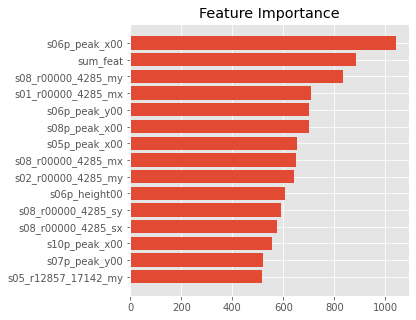

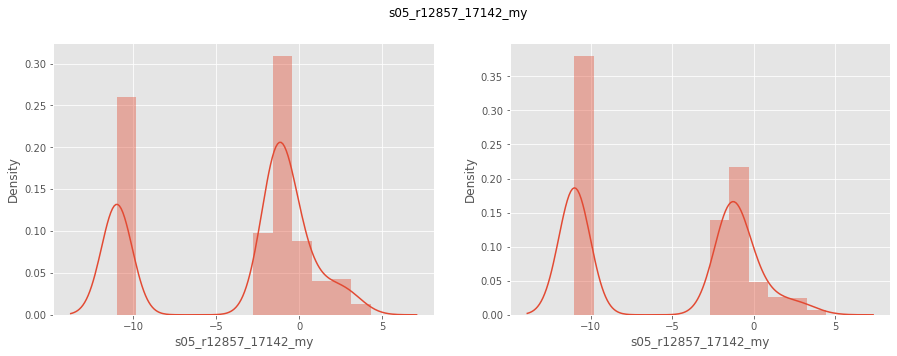

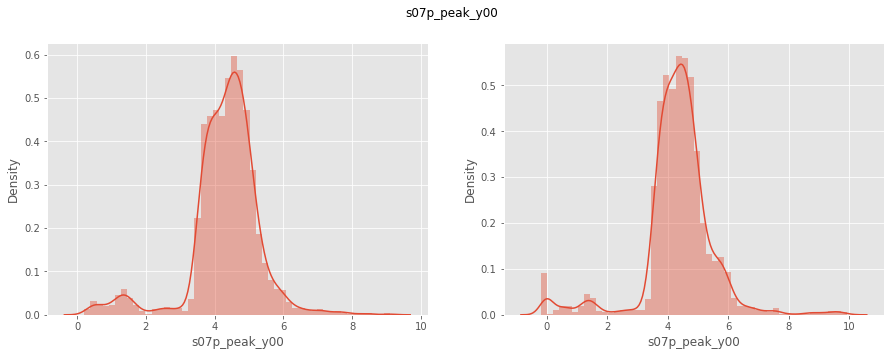

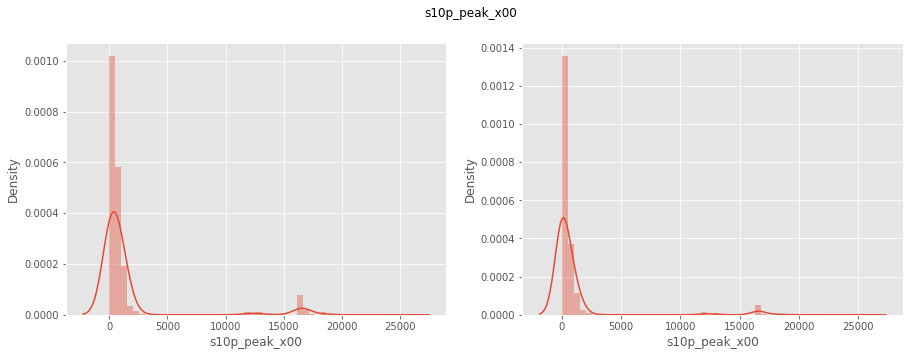

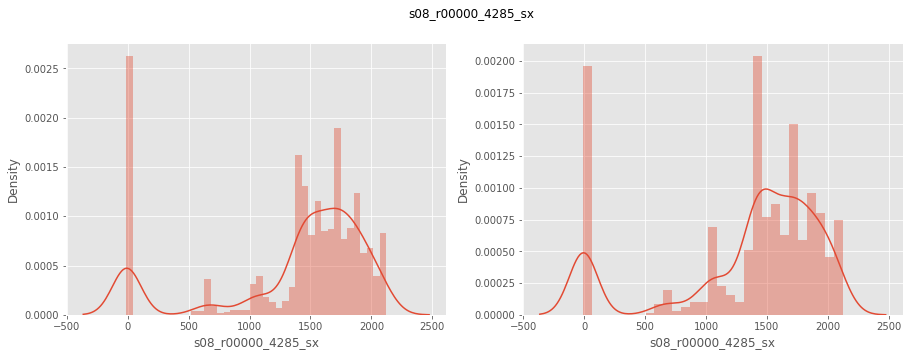

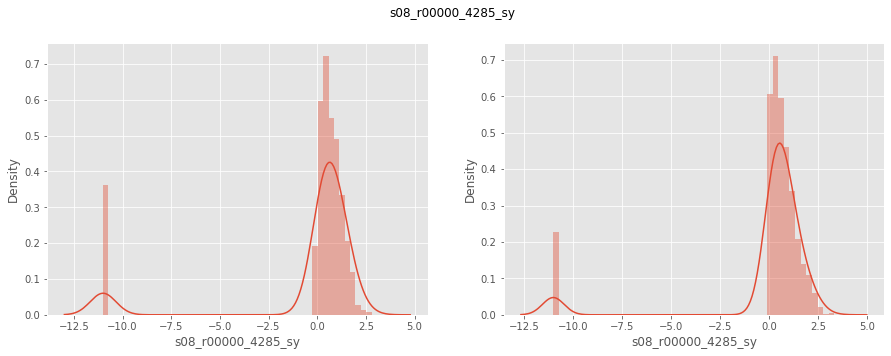

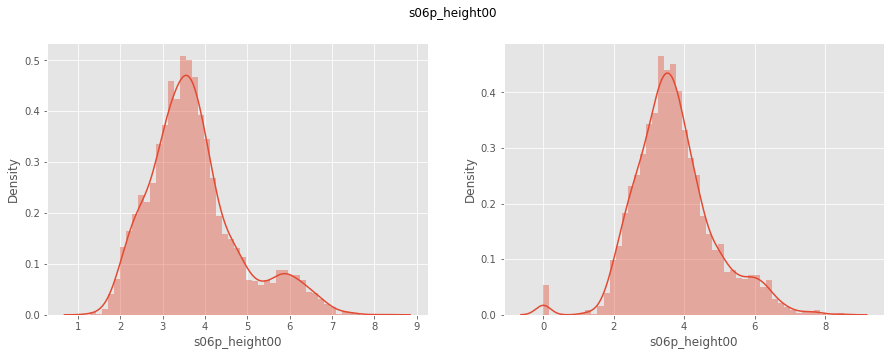

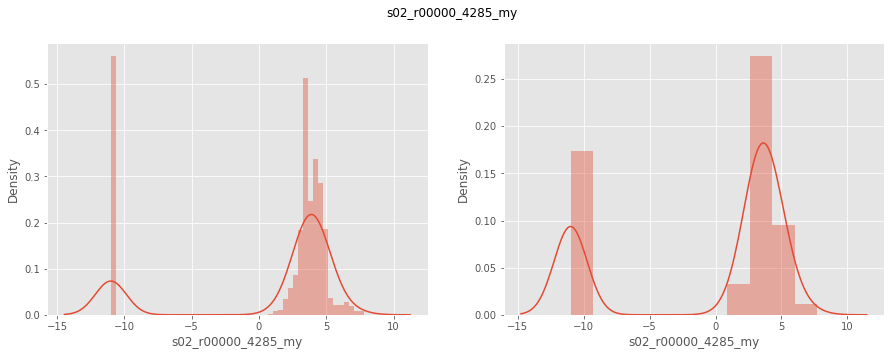

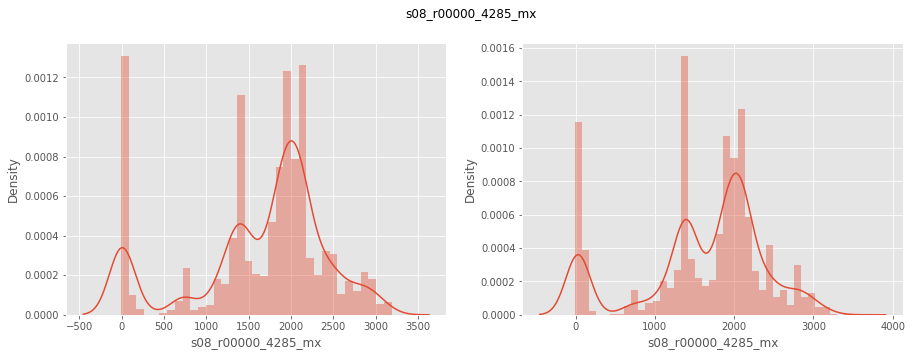

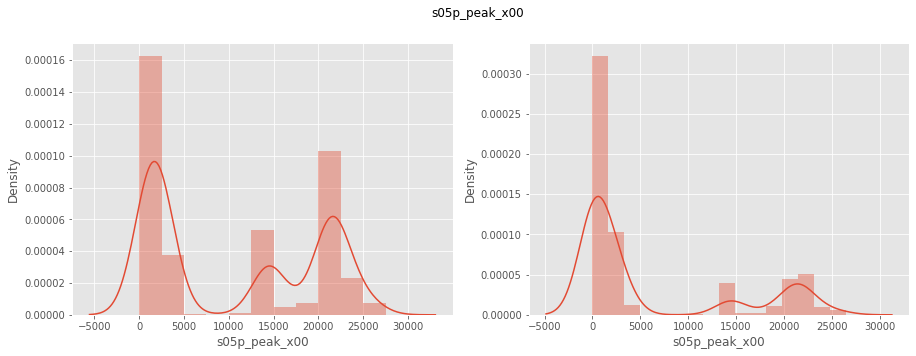

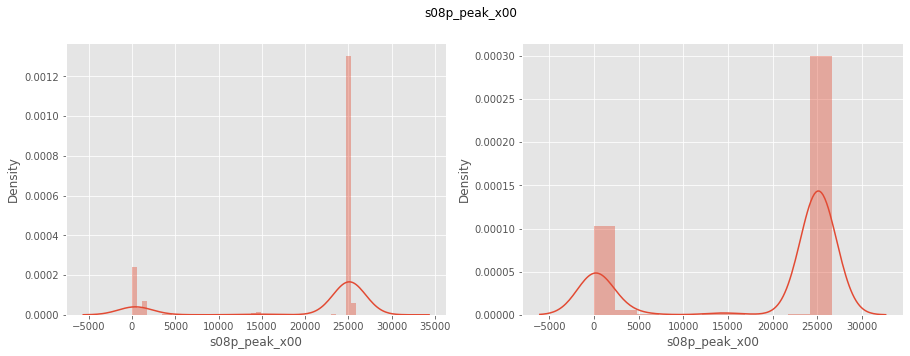

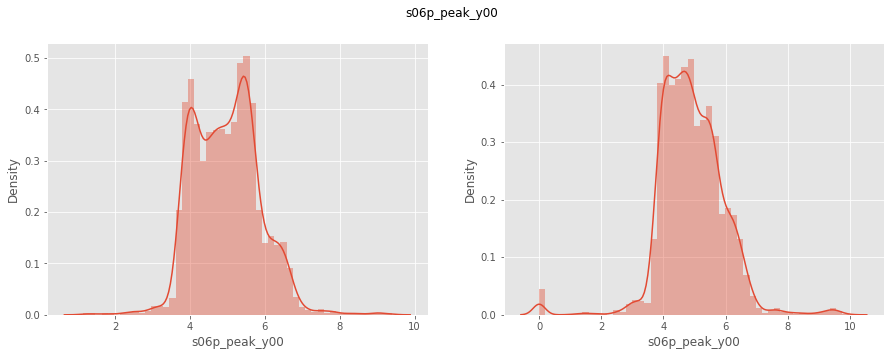

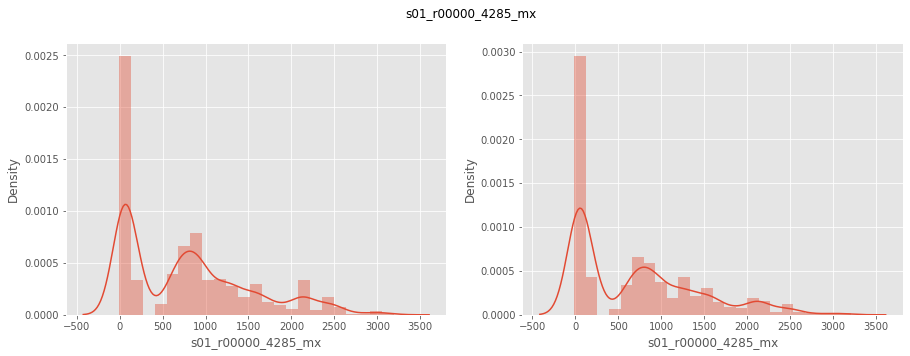

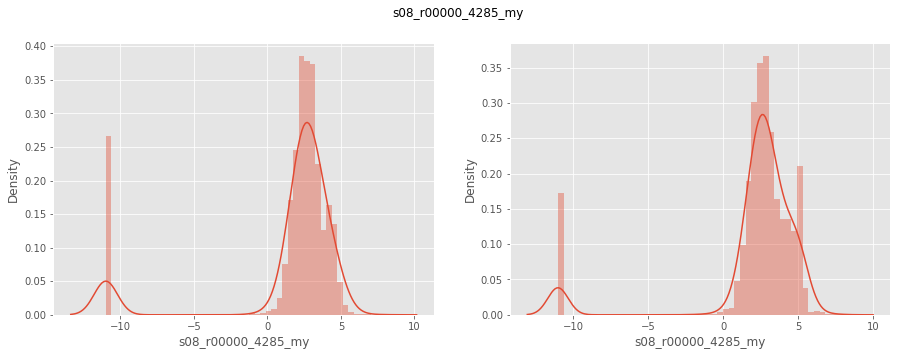

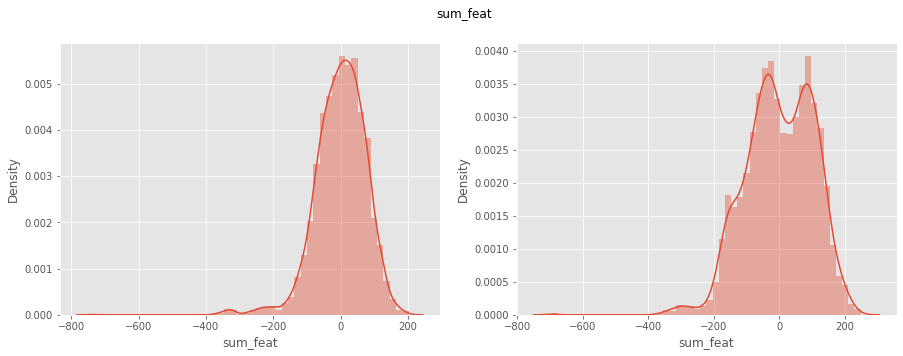

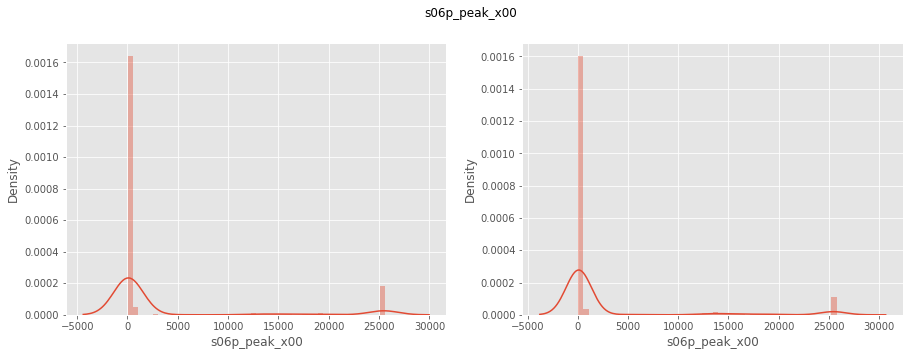

In [ ]:
import seaborn as sns

importances = model.feature_importances_
target_results = pd.DataFrame(importances, columns=[target])
target_results['feature'] = trn_x.columns
importances = target_results.sort_values(by = target).tail(15)
imp_feat = importances['feature'].values

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(importances['feature'], importances[target])
plt.show()

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=False, tfname='t4m_split_by_7_4431_samples', pfname='t4p_split_by_7')

for i in imp_feat:

  nullsm = t4m[i].isna().sum()
  nullsp = t4p[i].isna().sum()
  # print(f'feature {i}, nulls: m = {nullsm}, p = {nullsp}')
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  sns.distplot(t4m[i])
  plt.subplot(122)
  sns.distplot(t4p[i])
  plt.suptitle(i)
  plt.show()


# Prepare dataframe for prediction with best number of splits

In [ ]:
def get_test_data(nparts):

  postf = f'split_by_{nparts}'
  fname = f'{homedir}t4p_{postf}.csv'

  if not canread(fname):

    z = zf.ZipFile(f'{homedir}ingv_test.zip')

    testfiles = z.namelist()

    X_input = pd.DataFrame()
    labels = pd.read_csv(f'{homedir}ingv_sample_submission.csv')
    for ind, row in tqdm_notebook(labels.iterrows(), total=labels.shape[0]):
      segment_id = row['segment_id']
      t = get_file_data(pd.read_csv(z.open(f'{segment_id}.csv')), segment_id, nparts = nparts)
      t['time_to_eruption'] = 0
      X_input = pd.concat([X_input, t], ignore_index=True)

    X_input = X_input.fillna(0)
    X_input.to_csv(fname, index=False)

  t4p, X, y, z, feat, target, qt = prepare_train_data(scale=False, clfeat=[], nclust=0, postf=postf)

  return t4p[feat]


t4p_best_split = get_test_data(7)

# Use prepared train and test dataframes to make submission

In [ ]:
t1 = pd.read_csv(f'{homedir}t4m_10.csv')
t2 = pd.read_csv(f'{homedir}t4m_sfft_split_by_6.csv')
t2.drop(columns='time_to_eruption', inplace=True)

extensionsToCheck3 = ['_mx', '_my', '_sx', '_sy']
lfeat = [i for i in t2.columns if not any(ext in i for ext in extensionsToCheck3)]
# lfeat.append('segment_id')
t2 = t2[lfeat].copy()

t = t1.merge(t2, how='left', on='segment_id')
t.to_csv(f'{homedir}t4m_10_sfft_split_by_6.csv', index=False)

t1 = pd.read_csv(f'{homedir}t4p_10.csv')
t2 = pd.read_csv(f'{homedir}t4p_sfft_split_by_6.csv')
t2 = t2[lfeat].copy()

t = t1.merge(t2, how='left', on='segment_id')
t.to_csv(f'{homedir}t4p_10_sfft_split_by_6.csv', index=False)

In [ ]:
params_xgb = {
      'booster':'gbtree', 
      'colsample_bytree':0.8, # features percent used by tree
      'learning_rate':0.005, 
      'max_depth':8, 
      'n_estimators':3000,
      'subsample':0.9, # rows percent used by tree
      'tree_method':'gpu_hist',
      "max_bin": 2048,
      'eval_metric':'mae',
      'objective':'reg:squarederror', 
      'reg_alpha':0, 
      'reg_lambda':0, 
      'gamma':0,
      "predictor": "gpu_predictor",
      'verbosity':0, 'n_jobs':-1, 'nthread':None, 
  
      'importance_type':'gain', 
      'base_score':0.5, 
      'min_child_weight':1, 
      'scale_pos_weight':1, 
      'colsample_bylevel':1,
      'colsample_bynode':1, 

      'max_delta_step':0,
      'missing':None, 
      'random_state':101,
      'seed':None,
      'silent':None
  }

  params_lgb = {
      "n_estimators": 3000,
      "boosting_type": "gbdt",
      "metric": "mae",
      "num_leaves": 66,
      "learning_rate": 0.005,
      "colsample_bytree": 0.9,
      "subsample": 0.8,
      "verbose": -1,
      "random_state": 101,
      "n_jobs": -1,
      "device": "gpu"
  }

  if regr == 'xgb':
    model = XGBRegressor(**params_xgb)
  elif regr == 'lgb':
    model = lgb.LGBMRegressor(**params_lgb)

  model.fit(trn_x, trn_y,
      eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                    early_stopping_rounds = 50, verbose=False)

  if regr == 'xgb':
    best_iteration = model.get_booster().best_ntree_limit
    preds = model.predict(test_x, ntree_limit=best_iteration)

    importances = model.get_booster().get_score(importance_type='weight')
    keys = list(importances.keys())
    values = list(importances.values())
    importances = pd.DataFrame(data=values, index=keys, columns=["score"]).reset_index().sort_values(by = "score", ascending=False).head(5)
    importances.columns = ['feature', target]
    # print(importances)
    importances = importances['feature'].values

  elif regr == 'lgb':
    preds = model.predict(test_x, num_iteration=model.best_iteration_)

    importances = model.feature_importances_
    target_results = pd.DataFrame(importances, columns=[target])
    target_results['feature'] = trn_x.columns
    importances = target_results.sort_values(by = target).tail(5)
    # print(importances)
    importances = importances['feature'].values





In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 65.8MB 70kB/s 


In [ ]:
t = pd.read_csv(f'{homedir}t4m_10_sfft_split_by_6.csv')
feat = [i for i in t.columns if i not in ['segment_id', 'time_to_eruption']]

poorfeat = []

for i in feat:
  if t[i].nunique() < 100: poorfeat.append(i)

a = len(feat)
b = len(poorfeat)

print(f'delete {b} feat ot total {a}')
# tstats(t)

delete 149 feat ot total 880


Fold 0:
Training until validation scores don't improve for 50 rounds
[200]	training's l1: 3.05471e+06	training's rmse: 3.82301e+06	valid_1's l1: 4.22766e+06	valid_1's rmse: 5.54803e+06
[400]	training's l1: 1.35961e+06	training's rmse: 1.81086e+06	valid_1's l1: 3.16034e+06	valid_1's rmse: 4.45626e+06
[600]	training's l1: 804671	training's rmse: 1.08151e+06	valid_1's l1: 2.97334e+06	valid_1's rmse: 4.25009e+06
[800]	training's l1: 507117	training's rmse: 685007	valid_1's l1: 2.92306e+06	valid_1's rmse: 4.19458e+06
[1000]	training's l1: 326681	training's rmse: 445578	valid_1's l1: 2.89872e+06	valid_1's rmse: 4.16723e+06
[1200]	training's l1: 213823	training's rmse: 298127	valid_1's l1: 2.88475e+06	valid_1's rmse: 4.15119e+06
[1400]	training's l1: 141830	training's rmse: 205159	valid_1's l1: 2.87657e+06	valid_1's rmse: 4.14195e+06
[1600]	training's l1: 96058.9	training's rmse: 148443	valid_1's l1: 2.8725e+06	valid_1's rmse: 4.13739e+06
[1800]	training's l1: 66039.1	training's rmse: 113187	

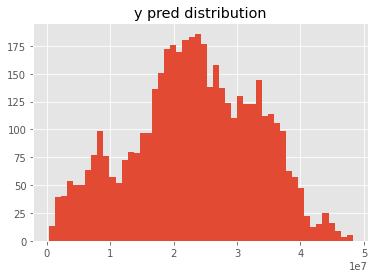

CPU times: user 32min, sys: 44.4 s, total: 32min 44s
Wall time: 16min 37s


In [ ]:
%%time

# t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True, tfname='t4m_10_sfft_split_by_6', pfname='t4p_10_sfft_split_by_6', dopca=False)

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True, tfname='t4m_10', pfname='t4p_10', dopca=False)

ver = 50
regr = 'lgb'
metric = 'rmse'
source = 'ver10'
n_fold = 5
ver = f'{ver}_{metric}_nopca_regr_{regr}_{source}'

folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params_xgb = {
    'booster':'gbtree', 
    'colsample_bytree':0.8, # features percent used by tree
    'learning_rate':0.005, 
    'max_depth':8, 
    'n_estimators':3000,
    'subsample':0.9, # rows percent used by tree
    'tree_method':'gpu_hist',
    "max_bin": 2048,
    'eval_metric':'mae',
    'objective':'reg:squarederror', 
    'reg_alpha':0, 
    'reg_lambda':0, 
    'gamma':0,
    "predictor": "gpu_predictor",
    'verbosity':0, 'n_jobs':-1, 'nthread':None, 

    'importance_type':'gain', 
    'base_score':0.5, 
    'min_child_weight':1, 
    'scale_pos_weight':1, 
    'colsample_bylevel':1,
    'colsample_bynode':1, 

    'max_delta_step':0,
    'missing':None, 
    'random_state':101,
    'seed':None,
    'silent':None
}

params_lgb = {
    "n_estimators": 5000,
    "boosting_type": "gbdt",
    "metric": "rmse",
    "num_leaves": 66,
    "learning_rate": 0.01,
    "colsample_bytree": 0.7,
    "subsample": 0.8,
    "verbose": -1,
    "random_state": 101,
    "n_jobs": -1,
    "device": "gpu"
}

params_cat = {
    'loss_function':'RMSE', 
    'eval_metric':'MAE', 
    'iterations':100000,
    'task_type':'GPU',
    'verbose':False,
    'learning_rate':0.02
}

y_pred = np.zeros(t4p.shape[0])
lmetric = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    # model = lgb.LGBMRegressor(**params)
    if regr == 'xgb':
      model = XGBRegressor(**params_xgb)
      model.fit(trn_x, trn_y, 
              eval_set= [(trn_x, trn_y), (val_x, val_y)], 
              eval_metric="mae", verbose=200, early_stopping_rounds=50
            )
    elif regr == 'lgb':
      model = lgb.LGBMRegressor(**params_lgb)
      model.fit(trn_x, trn_y, 
              eval_set= [(trn_x, trn_y), (val_x, val_y)], 
              eval_metric="mae", verbose=200, early_stopping_rounds=50
            )
    elif regr == 'cat':
      model = CatBoostRegressor(**params_cat)
      model.fit(trn_x, trn_y, 
                eval_set=(val_x, val_y), 
                verbose_eval=200, 
                early_stopping_rounds=50)
    

    # y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
    if regr == 'xgb':
      best_iteration = model.get_booster().best_ntree_limit
      y_pred += model.predict(t4p[feat], ntree_limit=best_iteration) / folds.n_splits
    elif regr == 'lgb':
      y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
      lmetric += model.best_score_['valid_1']['l1'] / folds.n_splits
      print(f'\nmae = {lmetric:.2e}\n')
    elif regr == 'cat':
      y_pred += model.predict(t4p[feat]) / folds.n_splits

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

my_submission = pd.DataFrame({
    'segment_id':t4p['segment_id'].values,
    'time_to_eruption':y_pred
})

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

my_submission[target] = abs(my_submission[target])

51
6my_submission.to_csv(f'{homedir}submission_{ver}.csv', index=False)

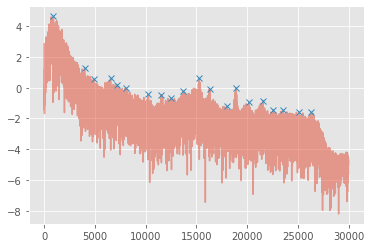

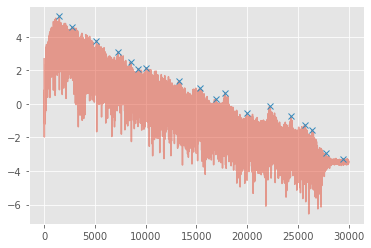

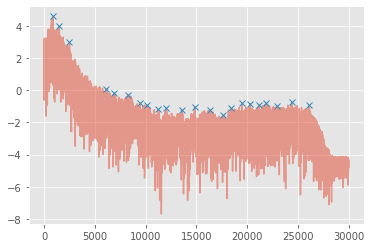

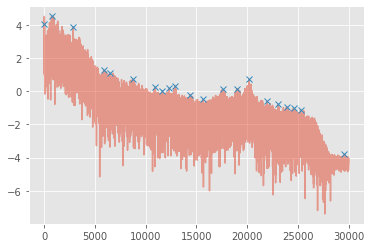

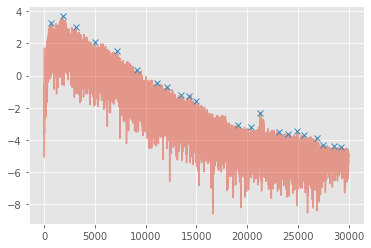

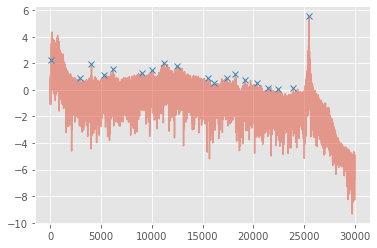

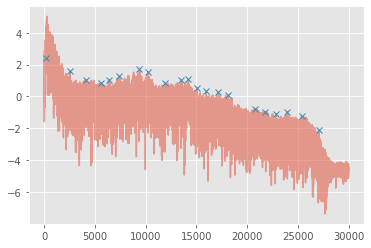

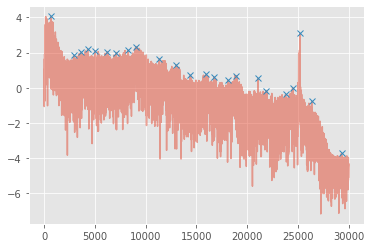

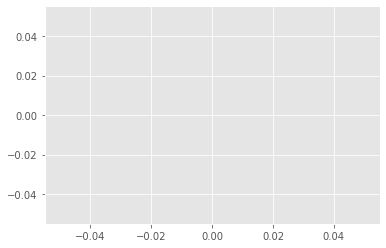

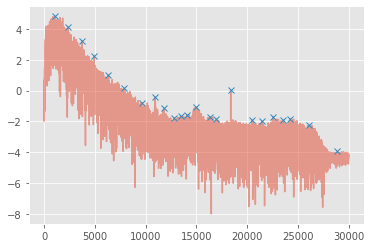

In [ ]:
segment_id = '859975969'
float32_cols = [f'sensor_{i}' for i in range(1,11)]00,3,20,
float32_cols = {c: np.float32 for c in float32_cols}
# t = get_file_data(pd.read_csv(z.open(f'{segment_id}.csv'), engine='c', dtype=float32_cols), segment_id, nparts = 5)
nparts = 5
t = pd.read_csv(z.open(f'{segment_id}.csv'))
r = [int(j*30000/nparts) for j in range(nparts+1)]

#################################


res = []
for i in [i for i in range(1,11)]:

    x, peaks = get_peaks(t, 'sensor_'+str(i))

    df1 = pd.DataFrame({'ind':peaks, 'x':x[peaks]})
    df2 = pd.DataFrame({'ind':np.linspace(0,30000,30001).astype(int)})
    df = df2.merge(df1, how='left', on='ind') # we need to get nans in order to interpolate them

    df = df.interpolate(method='linear', limit_direction='both', axis=0)

    data = df['x'].values
    data[0] = data[:5000].min()# first value is often the largest, so it isn't a peak. we need it to be not the largest if we want a first peak

    peaks, _ = find_peaks(data)

    prominences = peak_prominences(data, peaks)[0]
    contour_heights = data[peaks] - prominences

    results_half = peak_widths(data, peaks, rel_height=0.5)
    results_half[0]  # widths

    results_full = peak_widths(data, peaks, rel_height=1)
    results_full[0]  # widths


    ############## peaks found

    x, mins = get_mins(t, 'sensor_'+str(i))

    df1 = pd.DataFrame({'ind':mins, 'y':x[mins]})
    df = df.merge(df1, how='left', on='ind') # we need to get nans in order to interpolate them

    df = df.interpolate(method='linear', limit_direction='both', axis=0)

    data_mins = df['y'].values
    data_mins[0] = data_mins[:5000].max() # see comment above

    data_range = data-data_mins
    data_med = (data+data_mins)/2


    ############### mins found

    plt.plot(x, alpha=0.5)
    plt.plot(peaks, x[peaks], "x")
    plt.show()
    
    for j in range(len(r)-1):

        xpeaks = peaks[(peaks > r[j])&(peaks <= r[j+1])]
        ypeaks = x[xpeaks]
        ypeaks_range = data_range[xpeaks]
        ypeaks_med = data_med[xpeaks]

        if len(xpeaks) == 0:
          mx, sx, my, sy, ry, zy, ss = 0,0,0,0,0,0,0
        else:

          mx = round(np.median(xpeaks))
          sx = round(np.std(xpeaks))

          my = round(np.median(ypeaks), 2)
          sy = round(np.std(ypeaks), 2)
          
          ry = round(np.median(ypeaks_range), 2)
          zy = round(np.median(ypeaks_med), 2)
          
          ss = ry - zy
        
        r0, r1 = r[j], r[j+1]

        res.append([f's{i:02d}_r{r0:05d}_{r1}_mx', mx])
        res.append([f's{i:02d}_r{r0:05d}_{r1}_sx', sx])
        res.append([f's{i:02d}_r{r0:05d}_{r1}_my', my])
        res.append([f's{i:02d}_r{r0:05d}_{r1}_sy', sy])
        res.append([f's{i:02d}_r{r0:05d}_{r1}_ry', ry])
        res.append([f's{i:02d}_r{r0:05d}_{r1}_zy', zy])
        res.append([f's{i:02d}_r{r0:05d}_{r1}_ss', ss])
        
        
    ################################# range vars added

    peak_data = pd.DataFrame({
        'peak_x':peaks,
        'peak_y':data[peaks],
        'width':results_full[0],
        'height':prominences,
        'range':data_range[peaks],
        'range_med':data_med[peaks]
    }).sort_values(by='height', ascending=False)

    # peak_data
    cols = peak_data.columns

    tmp = peak_data.reset_index(drop=True).reset_index().head(7)
    tmp['index'] = tmp['index'].astype(str).apply(lambda x: x.zfill(2))

    tmp = tmp.melt(id_vars=['index'], value_vars=cols)#['peak_x', 'peak_y', 'width', 'height'])

    tmp['variable'] = tmp['variable'] + tmp['index']                
    #########################
    
    tmp = np.array(tmp[['variable', 'value']])
    for titem in tmp:
        res.append([f's{i:02d}p_' + titem[0], titem[1]])

In [ ]:
peak_data

,peak_x,peak_y,width,height,range,range_med
0,1070,4.824797,4999.000000,2.795584,3.407145,3.121224
15,18386,0.051213,5690.090338,2.358734,6.068352,-2.982964
7,10937,-0.426905,1001.974900,1.134401,4.481293,-2.667551
12,14944,-1.070424,2109.530824,0.939237,4.016858,-3.078853
18,22550,-1.679039,1420.218171,0.732284,2.128270,-2.743174
20,24219,-1.812472,3481.659342,0.693324,3.537254,-3.581099
13,16312,-1.686009,1240.839120,0.557034,4.814167,-4.093092
8,11800,-1.152890,613.604295,0.421215,2.841490,-2.573635
6,9600,-0.777957,1018.580307,0.395763,3.659185,-2.607550
4,6310,1.002026,763.695436,0.291847,2.409086,-0.202517


# Procedure to load train and test data

In [ ]:
from sklearn.decomposition import PCA

def prepare_data(scale=False, clfeat=[], nclust=0, tfname='t4m_10', pfname='t4p_10', dopca=True):
    
    t4m = pd.read_csv(f'{homedir}{tfname}.csv')
    t4p = pd.read_csv(f'{homedir}{pfname}.csv')

    t4m = t4m.fillna(0)
    t4m = t4m.sample(frac=1)
    t4p = t4p.fillna(0)
    # features = t4m.columns[1:-1]
    target = 'time_to_eruption'
    features = [i for i in t4m.columns if not i in [target, 'segment_id']]

    poorfeat = []

    for i in features:
      if t4m[i].nunique() < 100: poorfeat.append(i)    

    # features = [i for i in features if not i in poorfeat]

    cols = list(features)
    cols.append(target)
    df = t4m[cols].copy()
    t = df.corr()[target].reset_index()
    t[target] = abs(t[target])
    t.sort_values(by=target, ascending = False)

    t = t.loc[(t[target] > 0.05)&(t[target] < 1)].sort_values(by=target, ascending=False).reset_index()

    good_features = t['index'].values

    scaler = StandardScaler()

    # for train
    t = pd.DataFrame(scaler.fit_transform(t4m[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4m['sum_feat'] = t['sum_feat'].values
    t4m['mul_feat'] = t['mul_feat'].values
    t4m['s_m_feat'] = t['s_m_feat'].values


    # for test
    t = pd.DataFrame(scaler.fit_transform(t4p[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4p['sum_feat'] = t['sum_feat'].values
    t4p['mul_feat'] = t['mul_feat'].values
    t4p['s_m_feat'] = t['s_m_feat'].values

    feat = list(features)
    feat.append('sum_feat')
    feat.append('mul_feat')
    feat.append('s_m_feat')
    
    if nclust > 0:
        # clfeat = ['s06_r00000_5000_my', 's03_r05000_10000_my', 's10p_peak_x00',
        #       's04p_peak_x00', 's02_r15000_20000_sy', 's05_r05000_10000_my',
        #       's08p_peak_x00', 's06_r00000_5000_sy', 's02_r20000_25000_my',
        #       's06p_peak_y00', 's08_r00000_5000_my', 's05_r10000_15000_sy',
        #       's08p_peak_y02', 's06p_peak_x00', 'sum_feat']    

        kmeans = KMeans(init='k-means++', n_clusters=nclust, n_init=10)
        kmeans.fit(t4m[clfeat])
        t4m['cluster'] = kmeans.labels_
        t4p['cluster'] = kmeans.predict(t4p[clfeat])
        feat.append('cluster')
    

    if scale:
        scaler = StandardScaler()
        t4m[feat] = scaler.fit_transform(t4m[feat])
        t4p[feat] = scaler.transform(t4p[feat])
    
    X, y = t4m[feat], t4m[target]

    data = y.values.reshape(-1, 1)

    from sklearn.preprocessing import QuantileTransformer

    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal',
                             random_state=rng)

    z = qt.fit_transform(data)
    z_back = qt.inverse_transform(z)

#     plt.figure(figsize=(15,5))
#     plt.subplot(131)
#     plt.hist(data)
#     plt.title('y')

#     plt.subplot(132)
#     plt.hist(z, bins = 50)
#     plt.title('z')

#     plt.subplot(133)
#     plt.hist(z_back, bins = 50)
#     plt.title('inverse')

#     plt.show()
    
    
    if dopca:
      # pca = PCA() 
      pca = PCA(n_components=0.999,svd_solver="full")
      all_data_pca = pca.fit_transform(t4m[feat])
      t4m = pd.DataFrame(all_data_pca)
      t4m[target] = y

      id = t4p['segment_id'].values
      all_data_pca = pca.transform(t4p[feat])
      t4p = pd.DataFrame(all_data_pca)
      feat = t4p.columns
      t4p['segment_id'] = id

    #   if scale:
    #       scaler = StandardScaler()
    #       t4m[feat] = scaler.fit_transform(t4m[feat])
    #       t4p[feat] = scaler.transform(t4p[feat])

    
    return t4m, t4p, X, y, z, feat, target, qt

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True)

def de_qt(val):
    return qt.inverse_transform(val.reshape(-1, 1)).ravel()

In [ ]:
%%time

n_fold = 2
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params = {
    "n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 101,
    "nthread": -1,
    "device": "gpu",
}

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=200, early_stopping_rounds=50
           )

    y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

# my_submission = pd.DataFrame({
#     'segment_id':t4p['segment_id'].values,
#     'time_to_eruption':y_pred
# })

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

# my_submission.to_csv(f'submission_{ver}.csv', index=False)

Fold 0:
[LightGBM] [Warning] Unknown parameter: agging_freq
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: agging_freq
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: agging_freq
[LightGBM] [Warn

KeyboardInterrupt: ignored

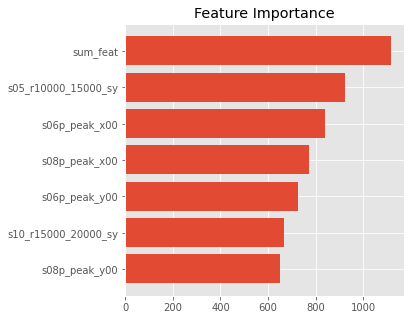

In [ ]:
importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[target])
target_results['feature'] = trn_x.columns

t = target_results.sort_values(by = target)
t = t.tail(7)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[target])
plt.show()

In [ ]:
t['feature'].values

# ['s06_r00000_5000_my', 's03_r05000_10000_my', 's10p_peak_x00',
# 's04p_peak_x00', 's02_r15000_20000_sy', 's05_r05000_10000_my',
# 's08p_peak_x00', 's06_r00000_5000_sy', 's02_r20000_25000_my',
# 's06p_peak_y00', 's08_r00000_5000_my', 's05_r10000_15000_sy',
# 's08p_peak_y02', 's06p_peak_x00', 'sum_feat']


array(['s08p_peak_y00', 's10_r15000_20000_sy', 's06p_peak_y00',
       's08p_peak_x00', 's06p_peak_x00', 's05_r10000_15000_sy',
       'sum_feat'], dtype=object)

In [ ]:
t

,time_to_eruption,feature
602,651,s08p_peak_y00
698,666,s10_r15000_20000_sy
434,726,s06p_peak_y00
595,770,s08p_peak_x00
427,841,s06p_peak_x00
313,923,s05_r10000_15000_sy
840,1116,sum_feat


In [ ]:
target_results.loc[(target_results['feature'].str.contains('range'))|
                    (target_results['feature'].str.contains('zy'))|
                   (target_results['feature'].str.contains('ss'))].sort_values(by='time_to_eruption', ascending=False).head(15)

,time_to_eruption,feature
13,319,s01_r05000_10000_zy
118,313,s02_r20000_25000_zy
63,297,s01p_range00
90,293,s02_r00000_5000_zy
275,292,s04p_range02
448,287,s06p_range_med00
38,272,s01_r25000_30000_ss
445,271,s06p_range04
444,258,s06p_range03
66,256,s01p_range03



Number of clusters = 3
Silhouette score = 0.3186350081588679

Number of clusters = 4
Silhouette score = 0.37590482770533085

Number of clusters = 5
Silhouette score = 0.38208077061003576

Number of clusters = 6
Silhouette score = 0.38728412000246565

Number of clusters = 7
Silhouette score = 0.32116011656133925

Number of clusters = 8
Silhouette score = 0.3353379455732746

Number of clusters = 9
Silhouette score = 0.3237458476111708

Number of clusters = 10
Silhouette score = 0.3267176535964246

Number of clusters = 11
Silhouette score = 0.29387557459037084

Number of clusters = 12
Silhouette score = 0.30211612168512786

Number of clusters = 13
Silhouette score = 0.30499887983784285

Number of clusters = 14
Silhouette score = 0.2916843211935906

Optimal number of clusters = 6


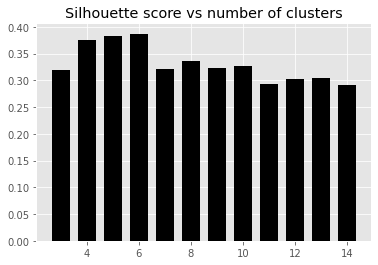

In [ ]:
clfeat = ['s06_r00000_5000_my', 's03_r05000_10000_my', 's10p_peak_x00',
       's04p_peak_x00', 's02_r15000_20000_sy', 's05_r05000_10000_my',
       's08p_peak_x00', 's06_r00000_5000_sy', 's02_r20000_25000_my',
       's06p_peak_y00', 's08_r00000_5000_my', 's05_r10000_15000_sy',
       's08p_peak_y02', 's06p_peak_x00', 'sum_feat']

clfeat = t['feature'].values

from sklearn import metrics
from sklearn.cluster import KMeans

# Initialize variables
scores = []
values = np.arange(3, 15)

X = t4m[clfeat].values
# Iterate through the defined range
for num_clusters in values:
    # Train the KMeans clustering model
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(X)
    score = metrics.silhouette_score(X, kmeans.labels_, 
                metric='euclidean', sample_size=len(X))

    print("\nNumber of clusters =", num_clusters)
    print("Silhouette score =", score)
                    
    scores.append(score)

# Plot silhouette scores
plt.figure()
plt.bar(values, scores, width=0.7, color='black', align='center')
plt.title('Silhouette score vs number of clusters')

# Extract best score and optimal number of clusters
num_clusters = np.argmax(scores) + values[0]
print('\nOptimal number of clusters =', num_clusters)

plt.show()

Fold 0:
Training until validation scores don't improve for 50 rounds.
[200]	training's l1: 5.76072e+06	valid_1's l1: 6.54385e+06
[400]	training's l1: 3.2698e+06	valid_1's l1: 4.73781e+06
[600]	training's l1: 2.13423e+06	valid_1's l1: 4.0594e+06
[800]	training's l1: 1.52844e+06	valid_1's l1: 3.77111e+06
[1000]	training's l1: 1.14738e+06	valid_1's l1: 3.63701e+06
[1200]	training's l1: 885676	valid_1's l1: 3.57652e+06
[1400]	training's l1: 693574	valid_1's l1: 3.54399e+06
[1600]	training's l1: 547215	valid_1's l1: 3.52088e+06
[1800]	training's l1: 433764	valid_1's l1: 3.50272e+06
[2000]	training's l1: 345067	valid_1's l1: 3.49058e+06
[2200]	training's l1: 275960	valid_1's l1: 3.48213e+06
[2400]	training's l1: 221317	valid_1's l1: 3.47578e+06
[2600]	training's l1: 178420	valid_1's l1: 3.47151e+06
[2800]	training's l1: 144623	valid_1's l1: 3.468e+06
[3000]	training's l1: 117695	valid_1's l1: 3.46604e+06
[3200]	training's l1: 96227.8	valid_1's l1: 3.46435e+06
[3400]	training's l1: 79206.1	va

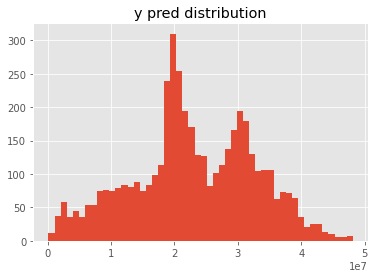

CPU times: user 5h 19min 45s, sys: 31.2 s, total: 5h 20min 16s
Wall time: 2h 42min 24s


In [ ]:
%%time

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True, clfeat=clfeat, nclust=num_clusters)

ver = 37
n_fold = 7
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params = {
    "n_estimators": 5000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 101,
    "nthread": -1,
    "device": "cpu",
}

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=200, early_stopping_rounds=50
           )

    y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

my_submission = pd.DataFrame({
    'segment_id':t4p['segment_id'].values,
    'time_to_eruption':y_pred
})

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

my_submission[target] = abs(my_submission[target])

my_submission.to_csv(f'submission_{ver}.csv', index=False)

In [ ]:
my_submission.to_csv(f'/content/drive/MyDrive/2 - рабочее/32 - PMI/random/submission_{ver}.csv', index=False)

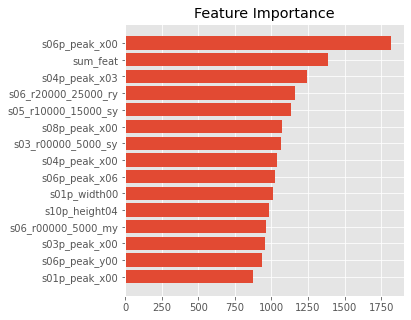

In [ ]:
importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[target])
target_results['feature'] = trn_x.columns

t = target_results.sort_values(by = target)
t = t.tail(15)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[target])
plt.show()

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

Fold 0, mae = 4546301
Fold 1, mae = 4633400


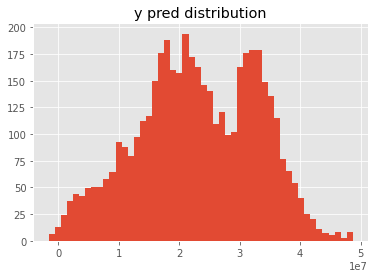

CPU times: user 54.8 s, sys: 17.3 s, total: 1min 12s
Wall time: 1min 1s


In [ ]:
%%time

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True)

ver = 38
n_fold = 2
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):

    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = CatBoostRegressor(verbose=False,eval_metric='MAE', task_type='GPU')
    
    model.fit(trn_x, trn_y)
    y_val = model.predict(val_x)
    lmetric = mean_absolute_error(val_y, y_val)
    lmetric = int(lmetric)
    print(f"Fold {n_fold}, mae = {lmetric}")

    y_pred += model.predict(t4p[feat]) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

my_submission = pd.DataFrame({
    'segment_id':t4p['segment_id'].values,
    'time_to_eruption':y_pred
})

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

my_submission[target] = abs(my_submission[target])

# my_submission.to_csv(f'/content/drive/MyDrive/2 - рабочее/32 - PMI/random/submission_{ver}.csv', index=False)

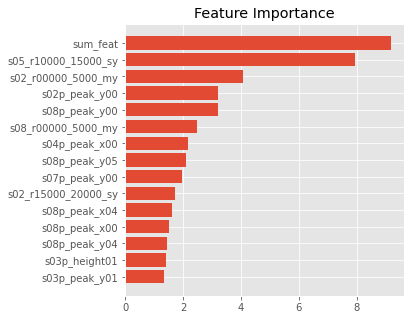

In [ ]:
importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[target])
target_results['feature'] = trn_x.columns

t = target_results.sort_values(by = target)
t = t.tail(15)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[target])
plt.show()

In [ ]:
t = target_results.sort_values(by = target)
t = t.tail(50)
t['feature'].values

array(['s01_r15000_20000_my', 's06_r00000_5000_my', 's05_r10000_15000_sx',
       's09_r15000_20000_sy', 's08p_height03', 's05_r25000_30000_sy',
       's09_r10000_15000_sy', 's02_r15000_20000_my', 's08_r00000_5000_mx',
       's06p_peak_x01', 's09p_peak_x00', 's07_r00000_5000_my',
       's05p_peak_x00', 's08p_height01', 's07p_height00',
       's05_r20000_25000_zy', 's06p_peak_x00', 's10p_peak_y00',
       's10p_peak_x00', 's08p_peak_x01', 's04p_peak_y00',
       's07_r00000_5000_sx', 's01_r25000_30000_ss', 's03_r05000_10000_my',
       's09p_height00', 's05_r25000_30000_ss', 's09_r10000_15000_my',
       's08_r10000_15000_ry', 's02_r10000_15000_my', 's08_r00000_5000_ry',
       's05_r20000_25000_my', 's05_r15000_20000_sy', 's09_r00000_5000_my',
       's02_r00000_5000_zy', 's08_r00000_5000_sy', 's03p_peak_y01',
       's03p_height01', 's08p_peak_y04', 's08p_peak_x00', 's08p_peak_x04',
       's02_r15000_20000_sy', 's07p_peak_y00', 's08p_peak_y05',
       's04p_peak_x00', 's08_r00000

In [ ]:
%%time

t4m, X, y, z, feat, target, qt = prepare_train_data(scale=True, postf='10')

params = {
    'booster':'gbtree', 
    'colsample_bytree':0.8, # features percent used by tree
    'learning_rate':0.005, 
    'max_depth':8, 
    'n_estimators':3000,
    'subsample':0.9, # rows percent used by tree
    'tree_method':'gpu_hist',
    "max_bin": 2048,
    'eval_metric':'mae',
    'objective':'reg:squarederror', 
    'reg_alpha':0, 
    'reg_lambda':0, 
    'gamma':0,
    "predictor": "gpu_predictor",
    'verbosity':1, 'n_jobs':-1, 'nthread':None, 
 
    'importance_type':'gain', 
    'base_score':0.5, 
    'min_child_weight':1, 
    'scale_pos_weight':1, 
    'colsample_bylevel':1,
    'colsample_bynode':1, 

    'max_delta_step':0,
    'missing':None, 
    'random_state':101,
    'seed':None,
    'silent':None
}
'''

https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
max_depth: determines how deeply each tree is allowed to grow during any boosting round.
subsample: percentage of samples used per tree. Low value can lead to underfitting.
colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
n_estimators: number of trees you want to build.
objective: determines the loss function to be used like reg:linear (deprecated) for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
alpha: L1 regularization on leaf weights. A large value leads to more regularization.
lambda: L2 regularization on leaf weights and is smoother than L1 regularization.'''

extensionsToCheck1 = ['_ss', '_zy', '_ry']
extensionsToCheck2 = ['range', 'range_med']
extensionsToCheck3 = ['_ss', '_zy', '_ry','range', 'range_med']

lfeat = [i for i in feat if not any(ext in i for ext in extensionsToCheck3)]

lfeat = ['s01_r15000_20000_my', 's06_r00000_5000_my', 's05_r10000_15000_sx',
       's09_r15000_20000_sy', 's08p_height03', 's05_r25000_30000_sy',
       's09_r10000_15000_sy', 's02_r15000_20000_my', 's08_r00000_5000_mx',
       's06p_peak_x01', 's09p_peak_x00', 's07_r00000_5000_my',
       's05p_peak_x00', 's08p_height01', 's07p_height00',
       's05_r20000_25000_zy', 's06p_peak_x00', 's10p_peak_y00',
       's10p_peak_x00', 's08p_peak_x01', 's04p_peak_y00',
       's07_r00000_5000_sx', 's01_r25000_30000_ss', 's03_r05000_10000_my',
       's09p_height00', 's05_r25000_30000_ss', 's09_r10000_15000_my',
       's08_r10000_15000_ry', 's02_r10000_15000_my', 's08_r00000_5000_ry',
       's05_r20000_25000_my', 's05_r15000_20000_sy', 's09_r00000_5000_my',
       's02_r00000_5000_zy', 's08_r00000_5000_sy', 's03p_peak_y01',
       's03p_height01', 's08p_peak_y04', 's08p_peak_x00', 's08p_peak_x04',
       's02_r15000_20000_sy', 's07p_peak_y00', 's08p_peak_y05',
       's04p_peak_x00', 's08_r00000_5000_my', 's08p_peak_y00',
       's02p_peak_y00', 's02_r00000_5000_my', 's05_r10000_15000_sy',
       'sum_feat']

trn_x, val_x, trn_y, val_y = train_test_split(X[feat], y, test_size=0.33, random_state=42)

model = XGBRegressor(**params)

model.fit(trn_x, trn_y,
    eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  early_stopping_rounds = 50, verbose=200)
    

# plt.figure()
# plt.hist(y_pred, bins=50)
# plt.title('y pred distribution')
# plt.show()

[0]	validation_0-mae:2.25878e+07	validation_1-mae:2.30317e+07
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[200]	validation_0-mae:8.55497e+06	validation_1-mae:9.20895e+06
[400]	validation_0-mae:3.64994e+06	validation_1-mae:5.0397e+06
[600]	validation_0-mae:1.88276e+06	validation_1-mae:3.88287e+06
[800]	validation_0-mae:1.14976e+06	validation_1-mae:3.53556e+06
[1000]	validation_0-mae:795564	validation_1-mae:3.40034e+06
[1200]	validation_0-mae:582097	validation_1-mae:3.3371e+06
[1400]	validation_0-mae:441032	validation_1-mae:3.30282e+06
[1600]	validation_0-mae:337555	validation_1-mae:3.28041e+06
[1800]	validation_0-mae:264381	validation_1-mae:3.26614e+06
[2000]	validation_0-mae:208147	validation_1-mae:3.25615e+06
[2200]	validation_0-mae:165485	validation_1-mae:3.24962e+06
[2400]	validation_0-mae:131855	validation_1-mae:3.24504e+06
[2600]	validation_0-mae:106160	validation_1-mae

Training until validation scores don't improve for 50 rounds
[500]	training's l1: 2.29202e+06	valid_1's l1: 4.01333e+06
[1000]	training's l1: 906890	valid_1's l1: 3.34013e+06
[1500]	training's l1: 462766	valid_1's l1: 3.24778e+06
[2000]	training's l1: 251938	valid_1's l1: 3.22349e+06
[2500]	training's l1: 145041	valid_1's l1: 3.21558e+06
[3000]	training's l1: 89081.4	valid_1's l1: 3.21185e+06
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 89081.4	valid_1's l1: 3.21185e+06


In [ ]:
%%time

# t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True)


params = {
    "n_estimators": 4000,
    "boosting_type": "gbdt",
    "metric": "rmse",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "colsample_bytree": 0.9,
    "subsample": 0.8,
    "verbose": 0,
    "random_state": 101,
    "n_jobs": -1,
    "device": "gpu",
}

extensionsToCheck1 = ['_ss', '_zy', '_ry']
extensionsToCheck2 = ['range', 'range_med']
extensionsToCheck3 = ['_ss', '_zy', '_ry','range', 'range_med']

lfeat = [i for i in feat if not any(ext in i for ext in extensionsToCheck3)]

# lfeat = ['s01_r15000_20000_my', 's06_r00000_5000_my', 's05_r10000_15000_sx',
#        's09_r15000_20000_sy', 's08p_height03', 's05_r25000_30000_sy',
#        's09_r10000_15000_sy', 's02_r15000_20000_my', 's08_r00000_5000_mx',
#        's06p_peak_x01', 's09p_peak_x00', 's07_r00000_5000_my',
#        's05p_peak_x00', 's08p_height01', 's07p_height00',
#        's05_r20000_25000_zy', 's06p_peak_x00', 's10p_peak_y00',
#        's10p_peak_x00', 's08p_peak_x01', 's04p_peak_y00',
#        's07_r00000_5000_sx', 's01_r25000_30000_ss', 's03_r05000_10000_my',
#        's09p_height00', 's05_r25000_30000_ss', 's09_r10000_15000_my',
#        's08_r10000_15000_ry', 's02_r10000_15000_my', 's08_r00000_5000_ry',
#        's05_r20000_25000_my', 's05_r15000_20000_sy', 's09_r00000_5000_my',
#        's02_r00000_5000_zy', 's08_r00000_5000_sy', 's03p_peak_y01',
#        's03p_height01', 's08p_peak_y04', 's08p_peak_x00', 's08p_peak_x04',
#        's02_r15000_20000_sy', 's07p_peak_y00', 's08p_peak_y05',
#        's04p_peak_x00', 's08_r00000_5000_my', 's08p_peak_y00',
#        's02p_peak_y00', 's02_r00000_5000_my', 's05_r10000_15000_sy',
#        'sum_feat']

trn_x, val_x, trn_y, val_y = train_test_split(X[feat], y, test_size=0.33, random_state=42)

model = lgb.LGBMRegressor(**params)

model.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        eval_metric="mae", verbose=200, early_stopping_rounds=50
        )


Training until validation scores don't improve for 50 rounds
[200]	training's l1: 5.51128e+06	training's rmse: 6.61192e+06	valid_1's l1: 6.29115e+06	valid_1's rmse: 7.68716e+06
[400]	training's l1: 2.9759e+06	training's rmse: 3.77672e+06	valid_1's l1: 4.43872e+06	valid_1's rmse: 5.7695e+06
[600]	training's l1: 1.82179e+06	training's rmse: 2.43206e+06	valid_1's l1: 3.7477e+06	valid_1's rmse: 5.04341e+06
[800]	training's l1: 1.24266e+06	training's rmse: 1.71116e+06	valid_1's l1: 3.46019e+06	valid_1's rmse: 4.72769e+06
[1000]	training's l1: 906890	training's rmse: 1.27202e+06	valid_1's l1: 3.34053e+06	valid_1's rmse: 4.59211e+06
[1200]	training's l1: 687025	training's rmse: 978293	valid_1's l1: 3.28811e+06	valid_1's rmse: 4.5328e+06
[1400]	training's l1: 526210	training's rmse: 765402	valid_1's l1: 3.25765e+06	valid_1's rmse: 4.49752e+06
[1600]	training's l1: 408233	training's rmse: 611009	valid_1's l1: 3.24094e+06	valid_1's rmse: 4.47821e+06
[1800]	training's l1: 319660	training's rmse: 

[0]	validation_0-mae:2.27013e+07	validation_1-mae:2.2951e+07
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[200]	validation_0-mae:8.88461e+06	validation_1-mae:9.61782e+06
[400]	validation_0-mae:4.01688e+06	validation_1-mae:5.57913e+06
[600]	validation_0-mae:2.17486e+06	validation_1-mae:4.38815e+06
[800]	validation_0-mae:1.40268e+06	validation_1-mae:4.01516e+06
[1000]	validation_0-mae:1.03681e+06	validation_1-mae:3.86269e+06
[1200]	validation_0-mae:805436	validation_1-mae:3.80415e+06
[1400]	validation_0-mae:658623	validation_1-mae:3.76162e+06
[1600]	validation_0-mae:540488	validation_1-mae:3.73278e+06
[1800]	validation_0-mae:447692	validation_1-mae:3.7162e+06
[1999]	validation_0-mae:382197	validation_1-mae:3.70725e+06
Fold 0, mae = 3707248
[0]	validation_0-mae:2.28568e+07	validation_1-mae:2.20148e+07
Multiple eval metrics have been passed: 'validation_1-mae' will be used for ea

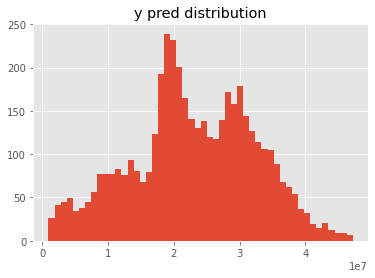

CPU times: user 2h 29min 23s, sys: 7.03 s, total: 2h 29min 30s
Wall time: 1h 15min 48s


In [ ]:
%%time

t4m, t4p, X, y, z, feat, target, qt = prepare_data(scale=True)

ver = 40
n_fold = 7
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):

    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = XGBRegressor(**params)
    
    model.fit(trn_x, trn_y,
        eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                      early_stopping_rounds = 50, verbose=200)

    y_val = model.predict(val_x)
    lmetric = mean_absolute_error(val_y, y_val)
    lmetric = int(lmetric)
    print(f"Fold {n_fold}, mae = {lmetric}")

    best_iteration = model.get_booster().best_ntree_limit
    y_pred += model.predict(t4p[feat], ntree_limit=best_iteration) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

my_submission = pd.DataFrame({
    'segment_id':t4p['segment_id'].values,
    'time_to_eruption':y_pred
})

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

my_submission[target] = abs(my_submission[target])

my_submission.to_csv(f'/content/drive/MyDrive/2 - рабочее/32 - PMI/random/submission_{ver}.csv', index=False)

In [ ]:
model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}